In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import time, pickle, warnings, json, os
from datetime import datetime
warnings.filterwarnings("ignore")

shuffle = True

## Train parameter

In [2]:
now = datetime.now().strftime("%Y%m%d%H%M%S")
root = os.getcwd()
input_ = {
   "START_DATE": "2022-05-25",
   "END_DATE": datetime.today().strftime("%Y-%m-%d"),
   "INIT_PATH": os.path.join(root, "data/init"),
   "TRAIN_LOG": os.path.join(root, "prog/logs/train.log"),
   "MODEL_PATH":  os.path.join(root, "data/models", now),
}

In [3]:
start = input_["START_DATE"]
end = input_["END_DATE"]
init_path = input_["INIT_PATH"]
model_path = input_["MODEL_PATH"]

start = datetime.strptime(start, "%Y-%m-%d")
end = datetime.strptime(end, "%Y-%m-%d")

if not os.path.isdir(model_path):
    os.makedirs(model_path)
    
model_detail = os.path.join(model_path, "model")
if not os.path.isdir(model_detail):
    os.makedirs(model_detail)

start, end, init_path, model_path, model_detail

(datetime.datetime(2022, 5, 25, 0, 0),
 datetime.datetime(2022, 11, 8, 0, 0),
 'd:\\Julie\\develop\\long_cheng\\data/init',
 'd:\\Julie\\develop\\long_cheng\\data/models\\20221108164309',
 'd:\\Julie\\develop\\long_cheng\\data/models\\20221108164309\\model')

## Data Loading

In [4]:
df0 = pd.DataFrame()
for dirs1 in os.listdir(init_path):
    if (int(dirs1) < start.year) or (int(dirs1) > end.year):
        continue

    for dirs2 in os.listdir(os.path.join(init_path, dirs1)): # dir - month
        if ((int(dirs1) <= start.year) & (int(dirs2) < start.month)) or ((int(dirs1) >= end.year) & (int(dirs2) > end.month)):
            continue
        
        for dirs3 in os.listdir(os.path.join(init_path, dirs1, dirs2)): # dir - day
            date = datetime.strptime(dirs3[:-4], "%Y%m%d")
            if (date < start) or (date > end):
                continue

            path = os.path.join(init_path, dirs1, dirs2, dirs3)
            df1 = pd.read_csv(path)
            df0 = pd.concat([df0, df1], ignore_index = True)

print(f"data shape: {df0.shape}")
df0["time"] = pd.to_datetime(df0["time"])
df0 = df0.sort_values("time")
df0.head(3)

data shape: (19533, 35)


,time,Gas_for_paper,Hourly_Production,Total_water,Quantitative_measurement_of_coiling_scan_frame,dry_strength_use,#1_Turbine_Motor_Side_Pressure,#1_Turbine_Free_Side_Pressure,#1_Turbine_Negative_Pressure,#1_Turbine_Negative_Pressure.1,...,#3_Vacuum_Pump_Motor_Side_Vibration,#3_Vacuum_Pump_Free_Side_Vibration,#4_Turbine_Free_Side_Pressure,#4_Turbine_Negative_Pressure,#4_Turbine_Negative_Pressure.1,#4_Turbine_Main_Motor_Current,#4_Vacuum_Pump_Motor_Side_Vibration,#4_Vacuum_Pump_Free_Side_Vibration,flow_nukp,headbox_feed_fan_pump
0,2022-10-21 06:47:00,1.224,36.9,40.0,105.3,NaN,-36.6,-33.2,-34.9,90.5,...,0.5,19.0,-49.1,-49.1,100.0,84.5,12.4,3.3,NaN,NaN
1,2022-10-21 06:48:00,1.219,36.9,40.0,104.8,NaN,-36.4,-33.0,-34.7,90.5,...,0.5,19.1,-49.0,-49.0,100.0,84.8,12.8,3.3,NaN,NaN
2,2022-10-21 06:49:00,1.206,36.9,40.0,105.1,NaN,-36.4,-32.9,-34.6,90.5,...,0.5,19.3,-49.1,-49.1,100.0,84.8,12.5,3.3,NaN,NaN


In [5]:
null = df0.isnull().sum()
null[null != 0]

dry_strength_use         180
flow_nukp                180
headbox_feed_fan_pump    180
dtype: int64

In [6]:
df0 = df0.dropna()
df0.to_csv("data/data.csv", index = False)

#### Select Features and Target

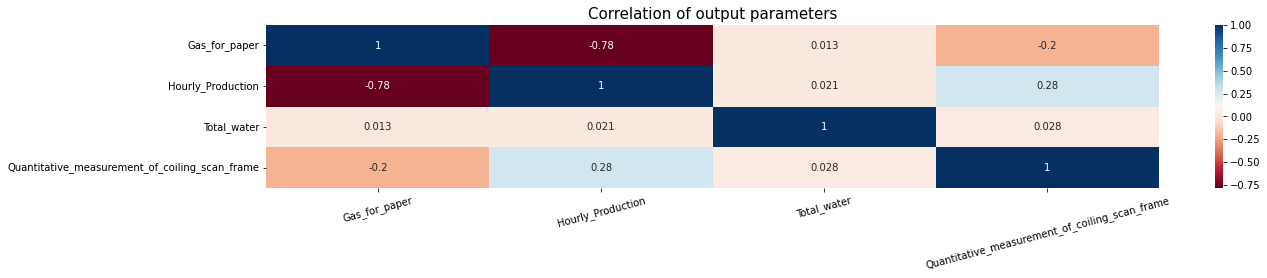

In [7]:
plt.figure(figsize=(20, 3))
sns.heatmap(data = df0.iloc[:, 1:5].corr(), annot=True, cmap = 'RdBu')
plt.title('Correlation of output parameters', fontsize = 15)
plt.xticks(rotation = 15)
plt.show()

In [8]:
target = "Hourly_Production"
features = df0.columns[5:].to_list()

In [9]:
df = df0.copy()
df = df.set_index("time")
df = df[[target] + features]
print(f"data shape: {df.shape}")
df.head(3)

data shape: (19353, 31)


,Hourly_Production,dry_strength_use,#1_Turbine_Motor_Side_Pressure,#1_Turbine_Free_Side_Pressure,#1_Turbine_Negative_Pressure,#1_Turbine_Negative_Pressure.1,#1_Turbine_Main_Motor_Current,#1_Vacuum_Pump_Motor_Side_Vibration,#1_Vacuum_Pump_Free_Side_Vibration,#2_Turbine_Motor_Side_Pressure,...,#3_Vacuum_Pump_Motor_Side_Vibration,#3_Vacuum_Pump_Free_Side_Vibration,#4_Turbine_Free_Side_Pressure,#4_Turbine_Negative_Pressure,#4_Turbine_Negative_Pressure.1,#4_Turbine_Main_Motor_Current,#4_Vacuum_Pump_Motor_Side_Vibration,#4_Vacuum_Pump_Free_Side_Vibration,flow_nukp,headbox_feed_fan_pump
time,,,,,,,,,,,,,,,,,,,,,
2022-10-21 09:47:00,36.2,0.0,-37.1,-32.3,-34.7,90.0,86.0,17.6,6.4,-39.6,...,0.5,19.4,-49.2,-49.2,100.0,83.5,13.1,3.3,0.0,0.0
2022-10-21 09:48:00,36.2,0.0,-37.0,-32.0,-34.5,90.0,86.4,17.6,6.4,-39.6,...,0.5,19.1,-49.2,-49.2,100.0,83.8,13.1,3.3,0.0,0.0
2022-10-21 09:49:00,36.2,0.0,-36.9,-32.1,-34.5,90.0,86.5,17.6,6.4,-39.5,...,0.5,19.5,-49.2,-49.2,100.0,84.3,13.1,3.3,0.0,0.0


### Slide window 10 min

In [10]:
#補上缺失的時間段
time_ = pd.date_range(df.index[0], df.index[-1], freq = "min").to_frame(name = "time")
df = pd.merge(df, time_, left_index = True, right_index = True, how = "right")

In [11]:
#每十分鐘取平均
df = df.rolling(10).mean()
df = df.dropna()
df.shape

(19218, 31)

In [12]:
# 刪除十分鐘內芯層泵啟停改變的sample
pump = [0, 2]
df = df.query("headbox_feed_fan_pump in @pump")
df.shape

(19191, 31)

#### Drop data leackage

import numpy as np
from tqdm import tqdm

#該筆資料和前一筆資料的距離
distance = [None]
for i in tqdm(range(1, len(df))):
    distance.append(np.linalg.norm(df.iloc[i].values - df.iloc[i-1].values))
df["distance"] = distance
df.head(3)

df["distance"].describe()

#距離小於中位數的sample刪除
median = df["distance"].median()
df = df.query("distance >= @median")
df = df.drop("distance", axis = 1)
df.shape

## EDA & Feature Engineering

#### Basic information

In [13]:
df.info()
# 沒有類別變數

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19191 entries, 2022-10-21 09:56:00 to 2022-11-04 23:59:00
Data columns (total 31 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Hourly_Production                    19191 non-null  float64
 1   dry_strength_use                     19191 non-null  float64
 2   #1_Turbine_Motor_Side_Pressure       19191 non-null  float64
 3   #1_Turbine_Free_Side_Pressure        19191 non-null  float64
 4   #1_Turbine_Negative_Pressure         19191 non-null  float64
 5   #1_Turbine_Negative_Pressure.1       19191 non-null  float64
 6   #1_Turbine_Main_Motor_Current        19191 non-null  float64
 7   #1_Vacuum_Pump_Motor_Side_Vibration  19191 non-null  float64
 8   #1_Vacuum_Pump_Free_Side_Vibration   19191 non-null  float64
 9   #2_Turbine_Motor_Side_Pressure       19191 non-null  float64
 10  #2_Turbine_Free_Side_Pressure        19191 non-null  float6

In [14]:
des = df.describe().T
des["unique"] = df.nunique()
des
# fearure包含負數，轉換時須注意
# 有constant feature，但須回推機台參數的最佳解，不可刪除

,count,mean,std,min,25%,50%,75%,max,unique
Hourly_Production,19191.0,37.942673,9.172352,0.00,38.300,39.88,43.47,49.59,2856
dry_strength_use,19191.0,3.774621,8.508290,0.00,0.000,0.00,0.00,35.00,249
#1_Turbine_Motor_Side_Pressure,19191.0,-35.337285,6.115653,-41.37,-37.740,-36.79,-34.80,-0.20,2185
#1_Turbine_Free_Side_Pressure,19191.0,-32.730732,6.011871,-38.04,-35.440,-34.48,-31.96,0.40,2151
#1_Turbine_Negative_Pressure,19191.0,-34.034665,5.918878,-39.39,-36.440,-35.55,-33.47,0.00,1976
#1_Turbine_Negative_Pressure.1,19191.0,88.838315,7.105622,50.00,88.000,90.00,92.00,94.00,156
#1_Turbine_Main_Motor_Current,19191.0,79.913737,15.427426,0.30,74.875,83.98,89.88,99.33,5578
#1_Vacuum_Pump_Motor_Side_Vibration,19191.0,17.681802,2.585467,0.60,17.400,17.81,18.60,21.49,898
#1_Vacuum_Pump_Free_Side_Vibration,19191.0,6.304831,1.780395,0.40,5.460,6.40,6.98,29.92,864
#2_Turbine_Motor_Side_Pressure,19191.0,-39.511519,6.544084,-42.29,-41.460,-40.85,-39.91,0.40,1031


In [15]:
df.isnull().sum().sum()
# 無 missing value

0

#### Target Analysis

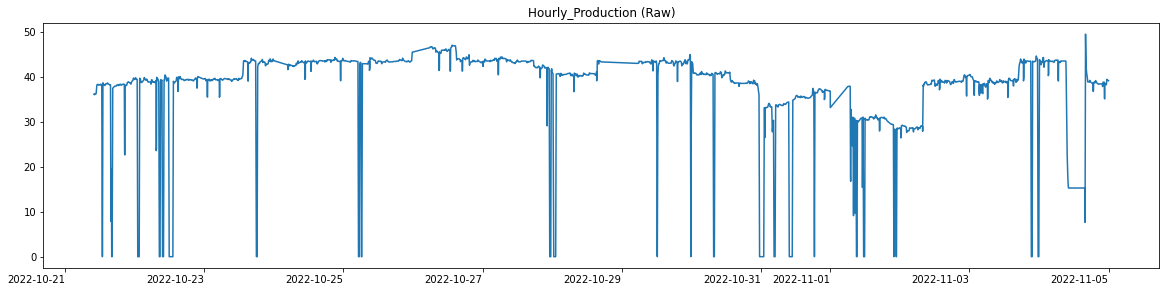

In [16]:
plt.figure(figsize=(20, 5)) 
df[target].plot()
plt.title(f'{target} (Raw)')
plt.xticks(rotation=0)
plt.show()
#正常Y應該要在40上下，Target有許多異常狀態，須砍掉異常sample

In [17]:
#Target異常狀態處理
df = df[(df[target] > 10)]
df.shape

(18508, 31)

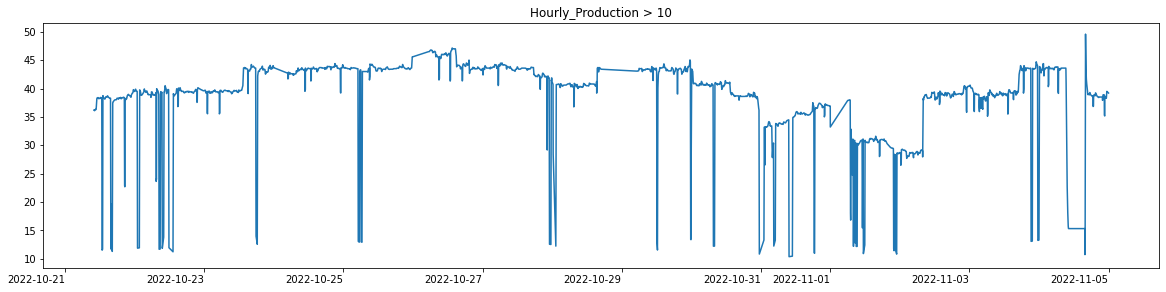

In [18]:
plt.figure(figsize=(20, 5)) 
df[target].plot()
plt.title(f'{target} > 10')
plt.xticks(rotation=0)
plt.show()

#### Correlation

In [19]:
df1 = df.corr().query("abs(Hourly_Production) >= 0.4")
df1 = df1[df1.index]

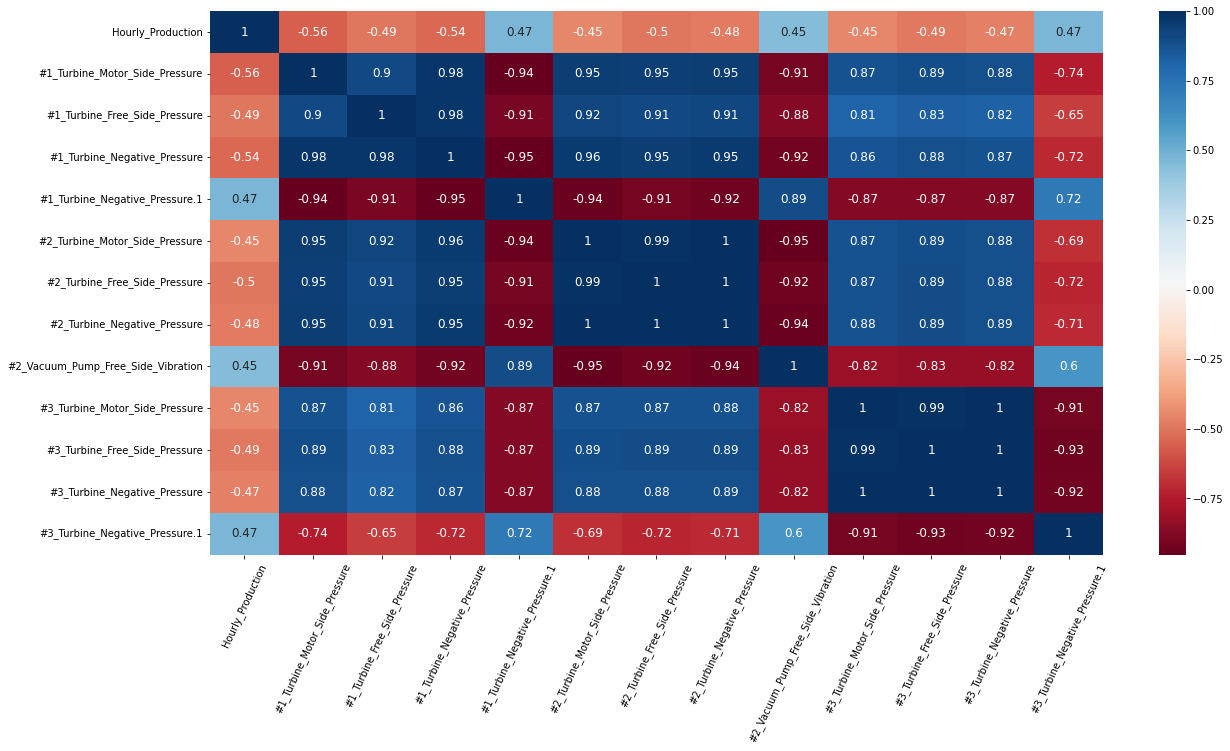

In [20]:
plt.figure(figsize=(20, 10))
sns.heatmap(data = df1, annot=True, cmap = 'RdBu', annot_kws = {"fontsize": 12})
plt.xticks(rotation = 65)
plt.show()

sns.pairplot(df[df1.index])

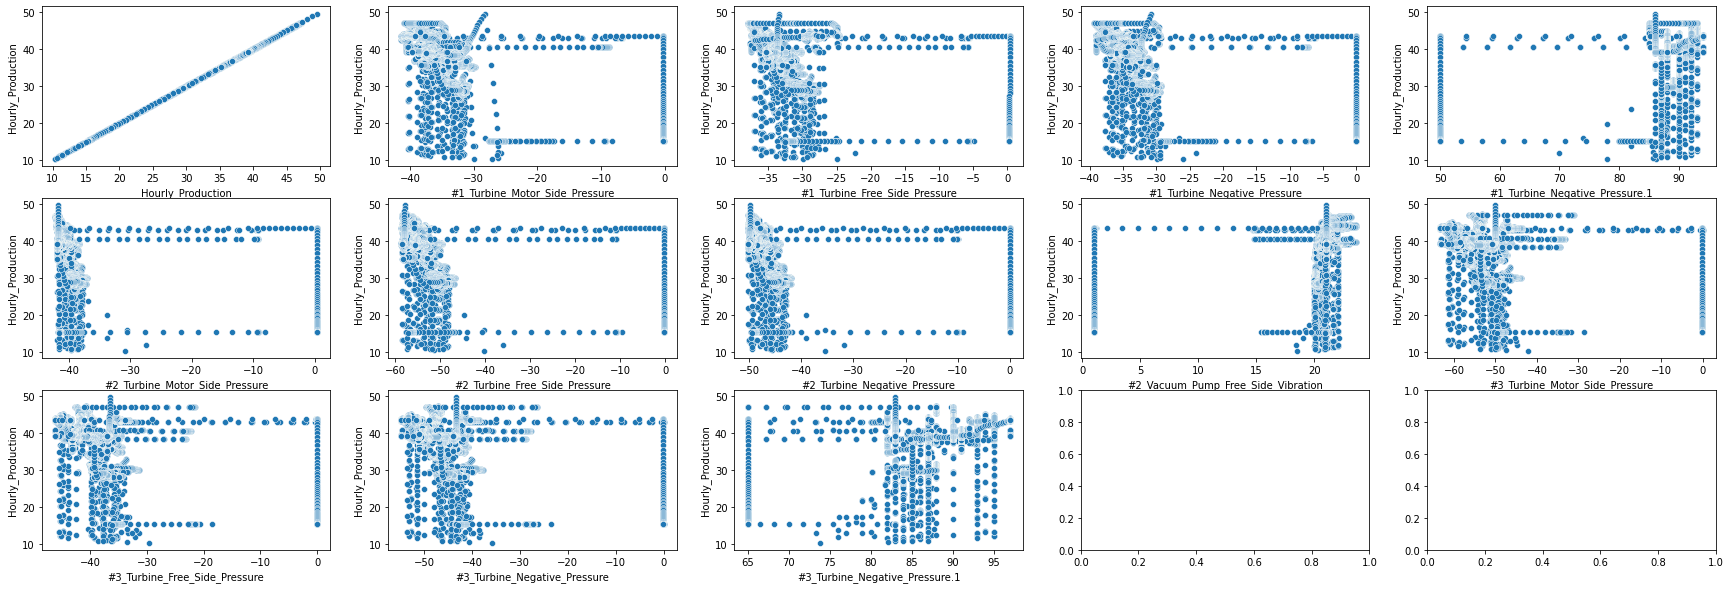

In [21]:
# "Relationship between features and target"
k = 0
a, b = 3, 5
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.scatterplot(x = df1.columns[k], y = target, data = df, ax = ax[i, j])
        k += 1

        if k >= len(df1.columns):
            break
plt.show()


#### Split train、test data

In [22]:
train, test = train_test_split(df, test_size = 0.2, shuffle = shuffle)
print(f"train shape: {train.shape} 、 test shape: {test.shape}")

train shape: (14806, 31) 、 test shape: (3702, 31)


#### Feature Analysis

In [23]:
train1, test1 = train.copy(), test.copy()
train1, valid1 = train_test_split(train1, test_size = 0.2, shuffle = shuffle)
train1, valid1, test1 = train1.sort_index(), valid1.sort_index(), test1.sort_index()
print(train1.shape, valid1.shape, test1.shape)

(11844, 31) (2962, 31) (3702, 31)


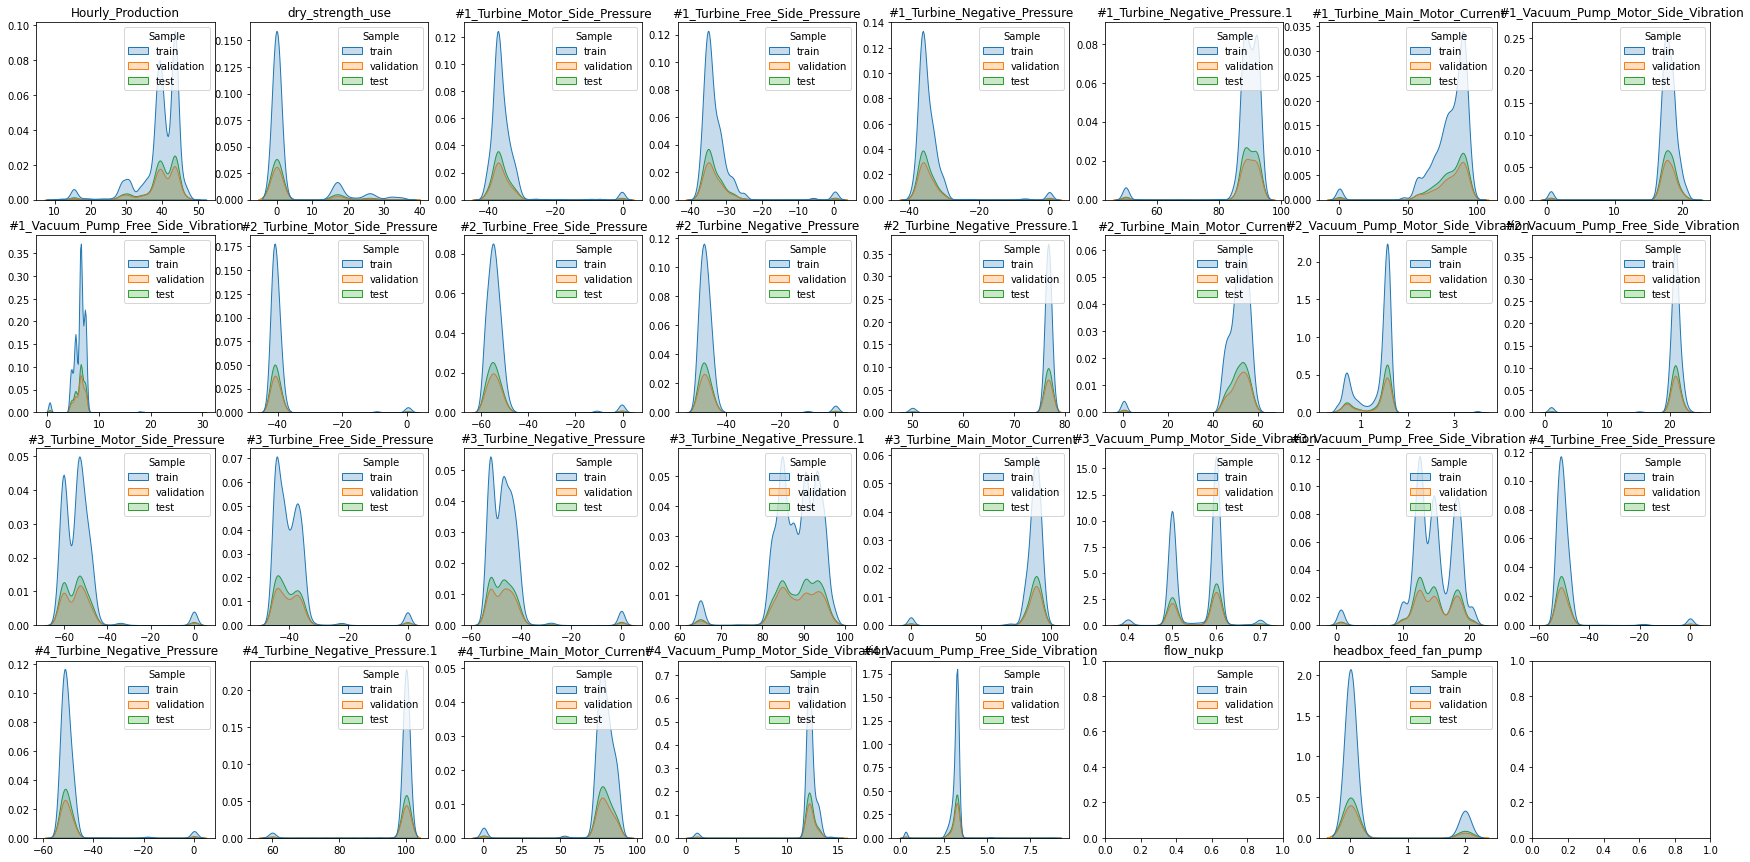

In [24]:
train2, valid2, test2 = train1.copy(), valid1.copy(), test1.copy()
train2["Sample"], valid2["Sample"], test2["Sample"] = "train", "validation", "test"
data = pd.concat([train2, valid2, test2])

k = 0
a, b = 4, 8
fig, ax = plt.subplots(a, b, figsize = (30, 15))
for i in range(a):
    for j in range(b):
        try:
            sns.kdeplot(data = data, x = data.columns[k], hue = "Sample", shade=True, ax = ax[i, j])
            ax[i, j].set(ylabel = None, xlabel = None, title = data.columns[k])
            k += 1
        except:
            continue
# 分佈相近

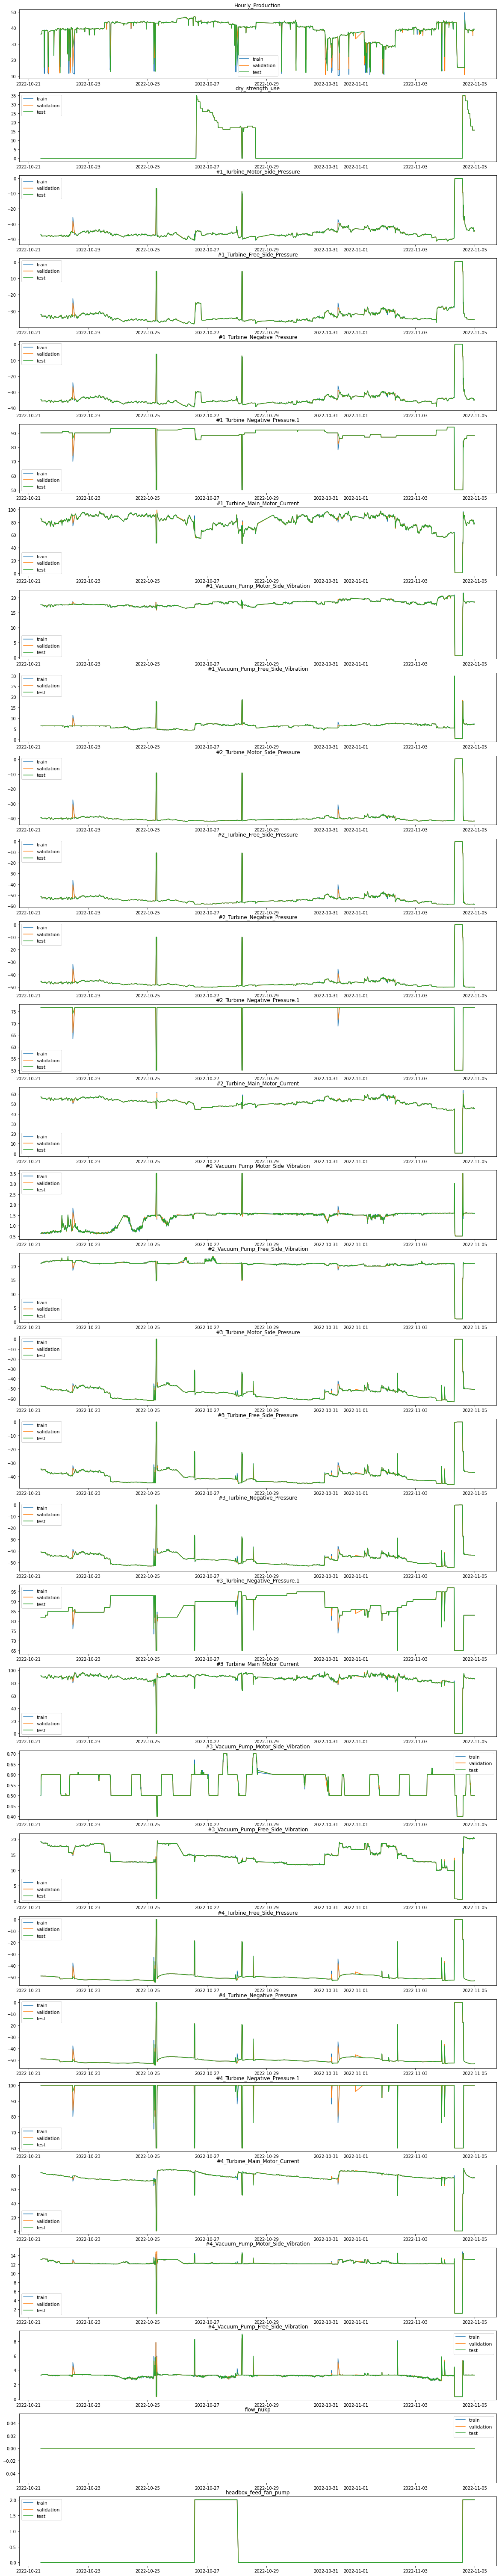

In [25]:
a, b = len(train1.columns), 1
k = 0
fig, ax = plt.subplots(a, b, figsize = (20, 110))
for i in range(a):
    ax[i].plot(train1[train1.columns[k]])
    ax[i].plot(valid1[valid1.columns[k]])
    ax[i].plot(test1[test1.columns[k]])
    ax[i].set_title(train1.columns[k])
    ax[i].legend(["train", "validation", "test"], fontsize = 11) 
    k += 1

#### Outlier

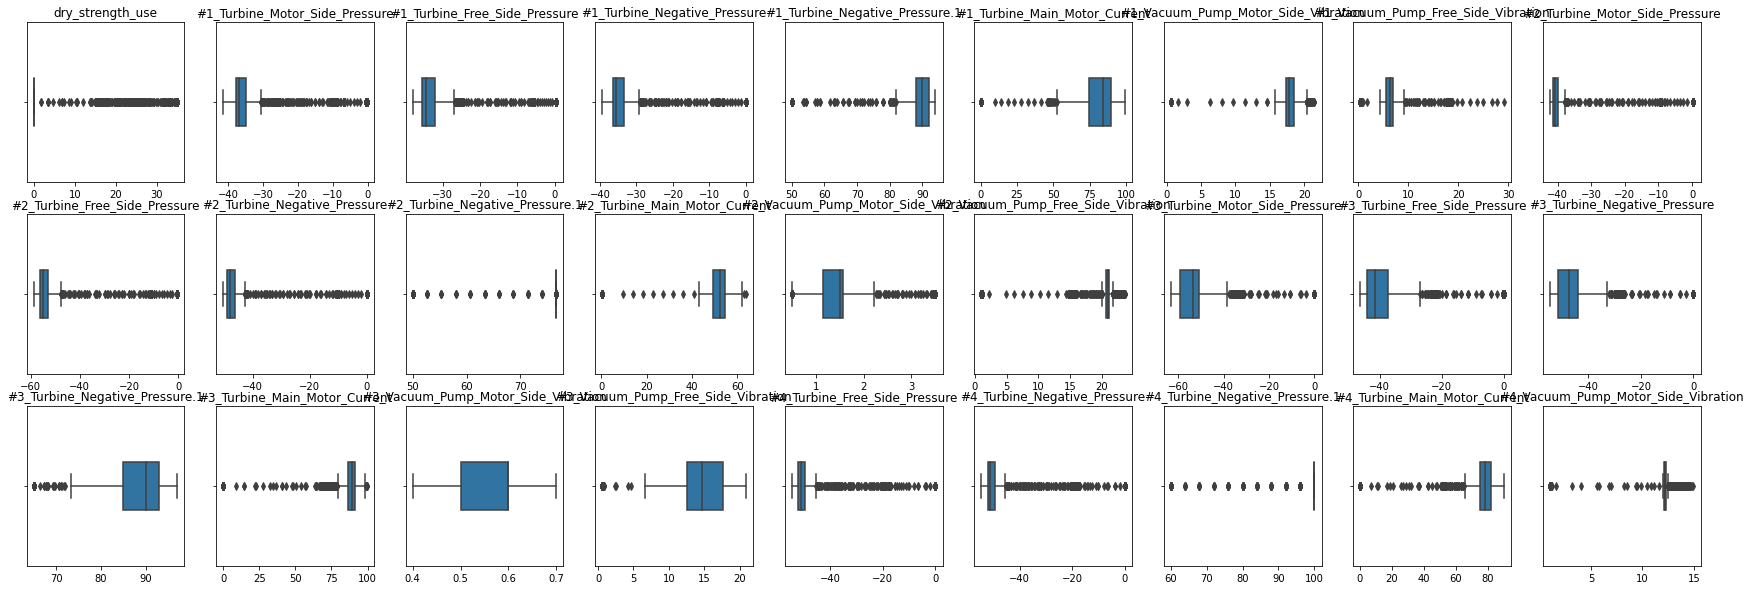

In [26]:
a, b = 3, 9
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = train, width = 0.3, ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None, title = features[k])
        k += 1

In [27]:
outlier_boundary = {}
for col in features:
    Q1   = train[col].quantile(0.25)
    Q3   = train[col].quantile(0.75)
    IQR  = Q3 - Q1
    min_ = Q1 - (1.5 * IQR)
    max_ = Q3 + (1.5 * IQR)
    
    train[col] = train[col].apply(lambda X: max_ if X > max_ else X)
    train[col] = train[col].apply(lambda X: min_ if X < min_ else X)

    test[col] = test[col].apply(lambda X: max_ if X > max_ else X)
    test[col] = test[col].apply(lambda X: min_ if X < min_ else X)

    outlier_boundary[col] = {
        "min": min_,
        "max": max_,
    }

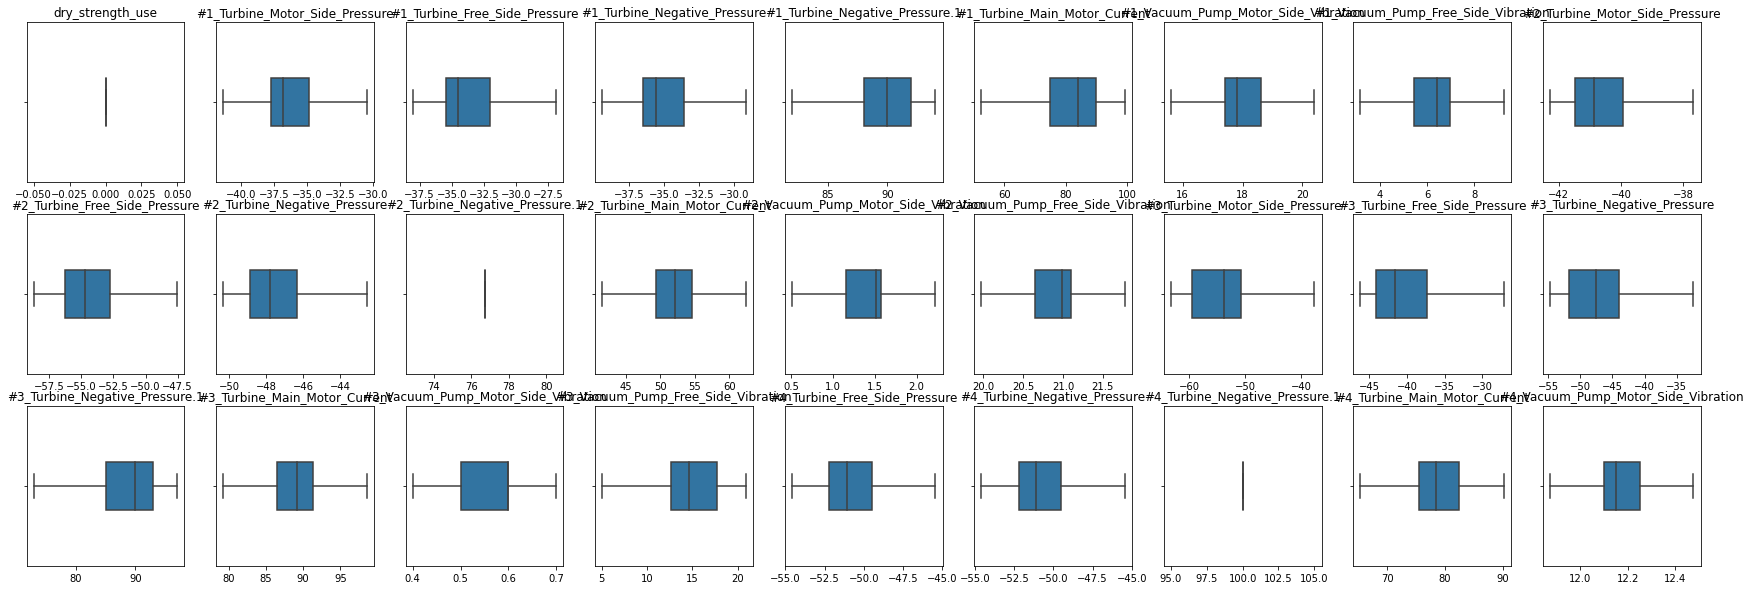

In [28]:
a, b = 3, 9
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 10))
for i in range(a):
    for j in range(b):
        sns.boxplot(x = features[k], data = train, width = 0.3, ax = ax[i, j])
        ax[i, j].set(xlabel = None, ylabel = None, title = features[k])
        k += 1

In [29]:
train.to_csv(f"{model_detail}\\preprocess.csv", index = False)

#### Skew

In [30]:
skewness = train[features].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

,Feature,Skew
0,#1_Turbine_Free_Side_Pressure,1.001692
1,#3_Turbine_Free_Side_Pressure,0.933806
2,#2_Turbine_Motor_Side_Pressure,0.868817
3,#1_Turbine_Negative_Pressure,0.862136
4,#4_Turbine_Negative_Pressure,0.829345
5,#4_Turbine_Free_Side_Pressure,0.829345
6,#3_Turbine_Negative_Pressure,0.761760
7,#4_Vacuum_Pump_Free_Side_Vibration,-0.796657
8,#1_Turbine_Main_Motor_Current,-0.930153
9,#2_Vacuum_Pump_Motor_Side_Vibration,-1.021778


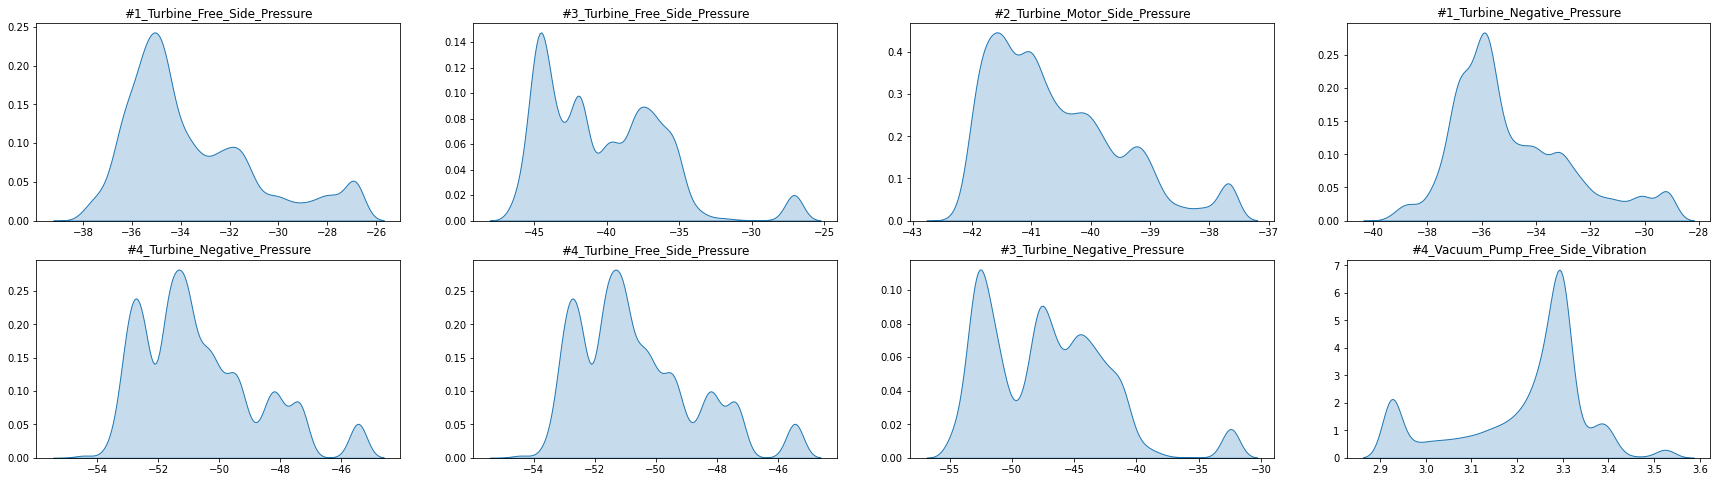

In [31]:
a, b = 2, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 8))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = skewness["Feature"].iloc[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skewness["Feature"].iloc[k])
        k += 1
        if k >= len(skewness):
            break

In [32]:
pt = PowerTransformer(method = 'yeo-johnson')
train[skewness["Feature"]] = pt.fit_transform(train[skewness["Feature"]])

In [33]:
test[skewness["Feature"]] = pt.transform(test[skewness["Feature"]])

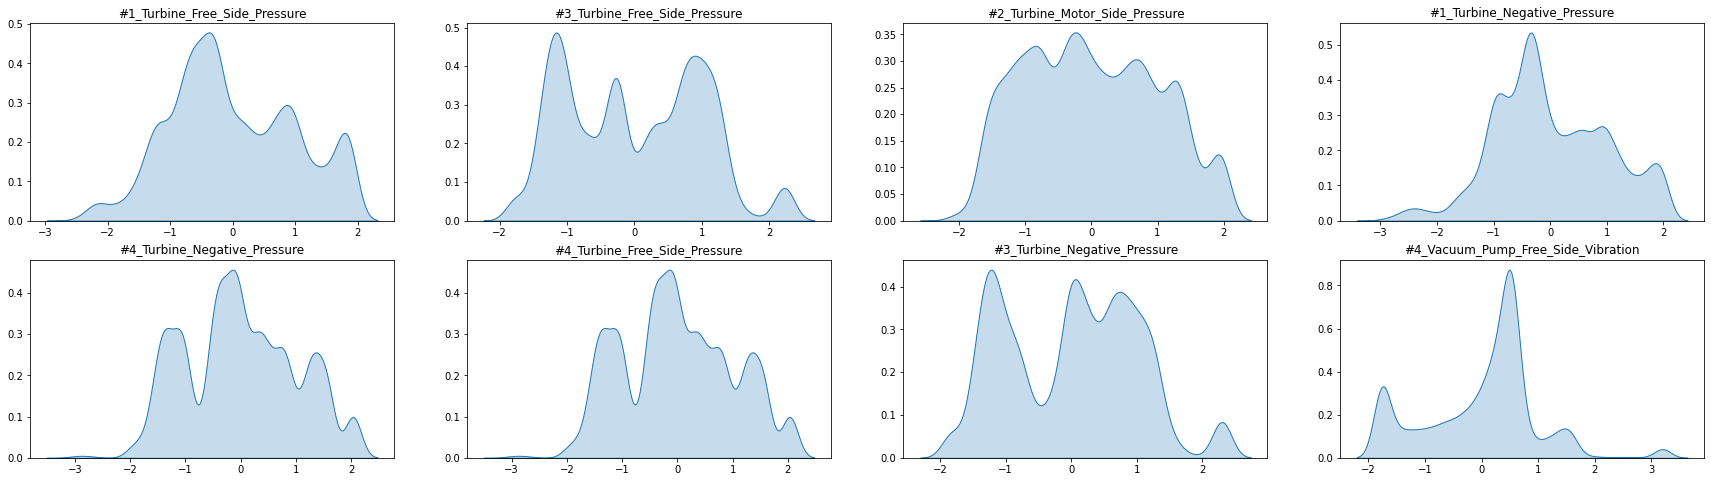

In [34]:
a, b = 2, 4
k = 0
fig, ax = plt.subplots(a, b, figsize = (30, 8))
for i in range(a):
    for j in range(b):
        sns.kdeplot(data = train, x = skewness["Feature"].iloc[k], shade=True, ax = ax[i, j])
        ax[i, j].set(ylabel = None, xlabel = None, title = skewness["Feature"].iloc[k])
        k += 1
        if k >= len(skewness):
            break

#### Scaling

In [35]:
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])

In [36]:
test[features] = scaler.transform(test[features])

## Modeling

#### Split data

In [37]:
train_data, test_data = train, test
train_data, valid_data = train_test_split(train_data, test_size = 0.3, shuffle = shuffle)
print(train_data.shape, valid_data.shape, test_data.shape)

(10364, 31) (4442, 31) (3702, 31)


### ML model

In [38]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

random_state = 99#None
models = {
    "                     Linear Regression": LinearRegression(),
    " Linear Regression (L2 Regularization)": Ridge(),
    " Linear Regression (L1 Regularization)": Lasso(),
    "                   K-Nearest Neighbors": KNeighborsRegressor(),
    "                        Neural Network": MLPRegressor(),
    "Support Vector Machine (Linear Kernel)": LinearSVR(),
    "   Support Vector Machine (RBF Kernel)": SVR(),
}
feat = features
X_train, y_train = train[feat], train[target]
X_test, y_test = test[feat], test[target]
for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                     Linear Regression trained.
 Linear Regression (L2 Regularization) trained.
 Linear Regression (L1 Regularization) trained.
                   K-Nearest Neighbors trained.
                        Neural Network trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.


In [39]:
from sklearn.model_selection import ShuffleSplit, cross_val_score
train_test_flag = 1
cv_flag = 0
score = []
for key, model in models.items():
    print(key)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_mse  = mean_squared_error(y_train, train_pred).round(2)
    test_mse   = mean_squared_error(y_test, test_pred).round(2)
    train_rmse =  (train_mse ** (1/2)).round(2)
    test_rmse  =  (test_mse ** (1/2)).round(2)
    train_mape = mean_absolute_percentage_error(y_train, train_pred)
    test_mape = mean_absolute_percentage_error(y_test, test_pred)
    train_r2   = r2_score(y_train, train_pred).round(2)
    test_r2    = r2_score(y_test, test_pred).round(2)


    if train_test_flag:
        col1 = [train_mse, test_mse, train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2]
        col2 = ["MSE_train", "MSE_test", "RMSE_train", "RMSE_test", "MAPE_train", "MAPE_test", "R2_train", "R2_test"]
    else:
        col1 = [test_mse, test_rmse, test_mape, test_r2]
        col2 =  ["MSE_test", "RMSE_test", "MAPE_test", "R2_test"]
    

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 5)
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["R2_cv"]
    
    score.append(col1)


index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score

                     Linear Regression
 Linear Regression (L2 Regularization)
 Linear Regression (L1 Regularization)
                   K-Nearest Neighbors
                        Neural Network
Support Vector Machine (Linear Kernel)
   Support Vector Machine (RBF Kernel)


,MSE_train,MSE_test,RMSE_train,RMSE_test,MAPE_train,MAPE_test,R2_train,R2_test
Linear Regression,13.59,14.67,3.69,3.83,0.068042,0.069417,0.61,0.58
Linear Regression (L2 Regularization),13.59,14.69,3.69,3.83,0.068079,0.069473,0.61,0.58
Linear Regression (L1 Regularization),18.46,18.75,4.30,4.33,0.090525,0.090537,0.47,0.46
K-Nearest Neighbors,0.97,1.80,0.98,1.34,0.007806,0.011420,0.97,0.95
Neural Network,4.74,5.63,2.18,2.37,0.032361,0.034414,0.87,0.84
Support Vector Machine (Linear Kernel),17.77,18.61,4.22,4.31,0.057119,0.059737,0.49,0.46
Support Vector Machine (RBF Kernel),7.74,8.37,2.78,2.89,0.032360,0.033682,0.78,0.76


### DL model

#### Select device

In [40]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

#### DataFrame transform to Torch Dataset

In [41]:
class Dataset_transform(Dataset):
    def __init__(self, df, features, target):
        self.n_samples = len(df)
        self.X = torch.Tensor(df[features].values)#.to(device)
        self.y = torch.Tensor(df[target].values.reshape(-1, 1))#.to(device)
                                            
    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [42]:
train_dataset = Dataset_transform(train_data, features, target)
valid_dataset = Dataset_transform(valid_data, features, target)
test_dataset = Dataset_transform(test_data, features, target)

#### DataLoader to use for batch

In [43]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = len(valid_dataset))
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset))

#### Model structure

In [44]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net  = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [45]:
epochs = 500
model = Model(input_size = len(features))#.to(device)
criterion = nn.MSELoss()#.to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

#### Initialize weights

In [46]:
# 初始化權重，使其符合常態分布
for m in model.modules():
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight)

#### Training model

In [47]:
# validate、test預測後的損失函數，以及相關分數
def eval_score(dataloader, model, criterion, mode = "eval"):
    with torch.no_grad():
        losses = 0
        pred1, y1 = torch.Tensor([]), torch.Tensor([])
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X) #預測
            loss = criterion(pred, y) #計算損失函數
            losses += loss.item()

            # pred, y = pred.cpu(), y.cpu()
            pred1 = torch.concat([pred1, pred])
            y1 = torch.concat([y1, y])

        losses /= (batch + 1)

        if mode == "train":
            return losses
            
        pred1 = pred1.detach().numpy()
        y1 = y1.detach().numpy()
        MSE = mean_squared_error(y1, pred1)
        RMSE = MSE ** (1/2)
        MAPE = mean_absolute_percentage_error(y1, pred1)
        SMAPE = (abs(y1 - pred1) / ((abs(y1) + abs(pred1)) / 2)).mean()
        R2 = r2_score(y1, pred1)
        
    return MSE, RMSE, MAPE, SMAPE, R2, pred1, y1

In [ ]:
# 建模
best_loss = np.inf
paitence = 30
train_losses = []
valid_losses = []
for epoch in range(epochs):
    train_loss = 0
    valid_loss = 0
    # train model
    model.train() # 模型為訓練模式
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        train_pred = model(X_train) #預測
        loss = criterion(train_pred, y_train) #計算損失函數

        optimizer.zero_grad() # 梯度在反向傳播前先清零
        loss.backward() # 反向傳播，計算權重對損失函數的梯度
        optimizer.step()  # 根據梯度更新權重
        train_loss += loss.item()
    train_loss /= (batch + 1)
    train_losses.append(train_loss)

    # validate model
    model.eval()# 模型為評估模式
    valid_loss = eval_score(valid_dataloader, model, criterion, mode = "train")
    valid_losses.append(valid_loss)

    print(f"Epoch {epoch} - train_loss: {train_loss:.4f},  valid_loss: {valid_loss:.4f}")

    # 損失函數連續30個epoches都沒下降的話就終止訓練
    if valid_loss < best_loss:
        best_loss = valid_loss
        remain_patience = paitence
    else:
        remain_patience -= 1
        if remain_patience == 0:
            print('early stop!')
            break
print("Done!")

#### Predict

In [49]:
data_name = ["Train", "Validation", "Test"]
dataloaders = [train_dataloader, valid_dataloader, test_dataloader]
score = pd.DataFrame(columns = ["MSE", "RMSE", "MAPE", "SMAPE", "R2"])
result = {}

for name, dataloader in zip(data_name, dataloaders):
    MSE, RMSE, MAPE, SMAPE, R2, pred, true = eval_score(dataloader, model, criterion)
    score.loc[name] = [MSE, RMSE, MAPE, SMAPE, R2]
    result[name] = {
        "true": true.reshape(-1),
        "pred": pred.reshape(-1),
    }

train_result = pd.DataFrame(result["Train"], index = train_data.index).sort_index()
valid_result = pd.DataFrame(result["Validation"], index = valid_data.index).sort_index()
test_result = pd.DataFrame(result["Test"], index = test_data.index).sort_index()

score["COUNT"] = [len(train_data), len(valid_data), len(test_data)]
score = score.round(4)
score

,MSE,RMSE,MAPE,SMAPE,R2,COUNT
Train,2.8071,1.6755,0.0254,0.0230,0.9212,10364
Validation,3.1829,1.7841,0.0265,0.0246,0.9062,4442
Test,3.8468,1.9613,0.0285,0.0258,0.8887,3702


In [50]:
with open(f'{model_path}/train.json', 'w') as f:
    json.dump(score.to_dict(), f)

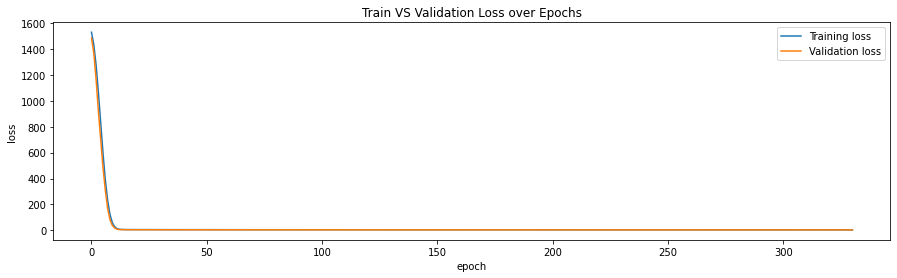

In [51]:
plt.figure(figsize=(15, 4))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title("Train VS Validation Loss over Epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig(f"{model_path}/chart.png")

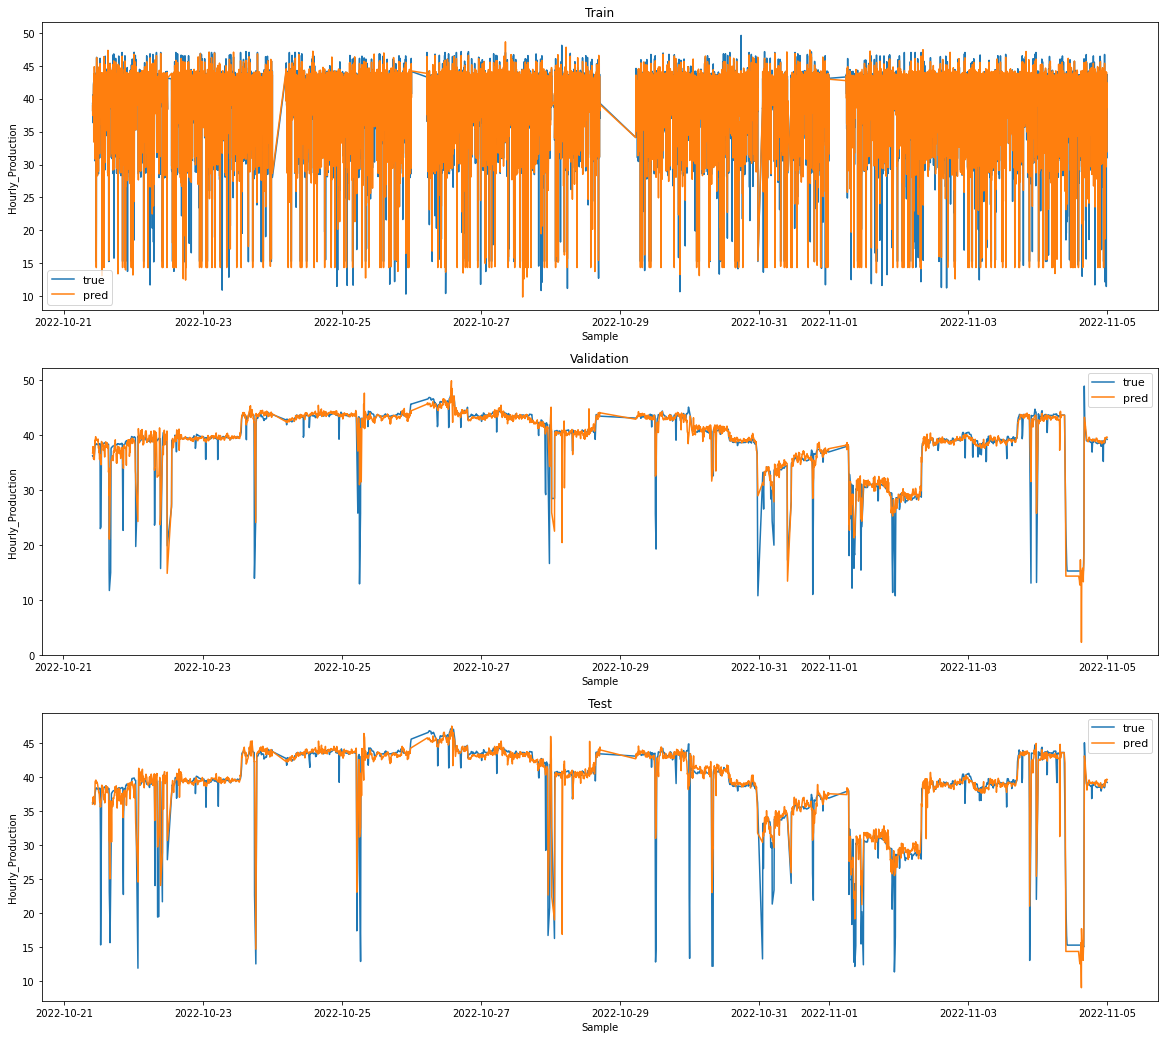

In [52]:
data = [train_result, valid_result, test_result]
fig, ax = plt.subplots(3, 1, figsize = (20, 18))
for i in range(3):
    ax[i].plot(data[i])
    ax[i].set(ylabel = target, xlabel = "Sample", title = data_name[i])
    ax[i].legend(["true", "pred"], fontsize = 11)
fig.savefig(f"{model_path}/pred.png")

In [53]:
from ptflops import get_model_complexity_info

mac, params = get_model_complexity_info(model, (len(features), ), as_strings=False, print_per_layer_stat=True, verbose=False)

print(f"Parameters: {params}")
print(f"MACs: {mac:.0f}")
print(f"FLOPs: {2*mac:.0f}，即{2*mac:.0f}次浮點運算")

Model(
  2.21 k, 100.000% Params, 2.27 KMac, 100.000% MACs, 
  (net): Sequential(
    2.21 k, 100.000% Params, 2.27 KMac, 100.000% MACs, 
    (0): Linear(992, 44.907% Params, 992.0 Mac, 43.643% MACs, in_features=30, out_features=32, bias=True)
    (1): LeakyReLU(0, 0.000% Params, 32.0 Mac, 1.408% MACs, negative_slope=0.01)
    (2): BatchNorm1d(64, 2.897% Params, 64.0 Mac, 2.816% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(1.06 k, 47.804% Params, 1.06 KMac, 46.458% MACs, in_features=32, out_features=32, bias=True)
    (4): LeakyReLU(0, 0.000% Params, 32.0 Mac, 1.408% MACs, negative_slope=0.01)
    (5): BatchNorm1d(64, 2.897% Params, 64.0 Mac, 2.816% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(33, 1.494% Params, 33.0 Mac, 1.452% MACs, in_features=32, out_features=1, bias=True)
  )
)
Parameters: 2209
MACs: 2273
FLOPs: 4546，即4546次浮點運算


## Save

In [54]:
# 儲存model
pickle.dump(features, open(f'{model_detail}/feat_order.pkl','wb'))
skew_feat = [list(train.columns[1:]).index(skewness["Feature"][i]) for i in range(len(skewness["Feature"]))]
pickle.dump(skew_feat, open(f'{model_detail}/skew_feat.pkl','wb'))
pickle.dump(outlier_boundary, open(f'{model_detail}/outlier_boundary.pkl','wb'))
pickle.dump(pt, open(f'{model_detail}/power_tf.pkl','wb'))
pickle.dump(scaler, open(f'{model_detail}/scaler.pkl','wb'))
torch.save(model.state_dict(), f"{model_detail}/nn_weights.pt") # 儲存權重

In [55]:
# 抓出各產出正負5的sample的所有feature之四分位數
range_path = f"{model_detail}/pred_range"
if not os.path.isdir(range_path):
    os.makedirs(range_path)
    
df1 = pd.read_csv(f"{model_detail}/preprocess.csv")

for i in range(10, 46):
    df_range = df1[(df1[target] <= i+5) & (df1[target] >= i-5)]
    df_range = df_range.describe().T[["min", "25%", "50%", "75%", "max"]]
    df_range = df_range.reset_index()
    df_range = df_range.rename(columns = {"index": "feature"})
    
    df_range.to_csv(f"{range_path}/{i}.csv", index = False)

In [56]:
# 前端的預設參數
df40_range = pd.read_csv(f"{range_path}/40.csv")
df40_range = df40_range.set_index("feature")
df40_range.columns = ["q0", "q1", "q2", "q3", "q4"]

with open(f'{model_path}/parameter.json', 'w') as f:
    json.dump(df40_range.T.to_dict(), f)

## Input X optimize

### Predict parameter

In [57]:
root = os.getcwd()
models = os.listdir(os.path.join(root, "data", "models"))
model_time = sorted(models)[-1]
model_path = os.path.join(root, "data", "models", str(model_time))
print(f"The path of latest model is {model_path}.")

The path of latest model is d:\Julie\develop\long_cheng\data\models\20221108164309.


In [58]:
now = datetime.now().strftime("%Y%m%d%H%M%S")
predict_path = os.path.join(root, "data", "predictions", now)
if not os.path.isdir(predict_path):
    os.makedirs(predict_path)
predict_path

'd:\\Julie\\develop\\long_cheng\\data\\predictions\\20221108164903'

In [59]:
# input X
import random

target = "Hourly_Production"

# 輸入參數
df0 = pd.read_csv(os.path.join(root, "data", "data.csv"))
features = df0.columns[5:].to_list()
df_lower40 = df0[(df0[target] < 40)][target]
ind = random.choice(df_lower40.index)
output = df0.loc[ind, target]
X0 = df0.iloc[ind: ind+1][features]

# 指定不可調動的參數
fixed_mask = [random.randint(0, 1) for i in range(len(features))]

print("initial X =", X0.values)
print("fixed mask =", fixed_mask)
print("output = ", output)


# 轉為實際輸入的input格式
input_data = {X0.columns[i]: {"init": X0.values[0][i], "fixed": random.randint(0, 1)} for i in range(X0.shape[1])}
input_data[target]= {"init": 41}

with open(f'{predict_path}/input.json', 'w') as f:
    json.dump(input_data, f)

initial X = [[  0.  -35.3 -33.3 -34.3  88.   78.3  18.6   7.  -40.5 -54.  -47.3  76.7
   52.4   1.6  20.5 -51.4 -39.3 -45.4  88.   92.9   0.6  15.1 -51.1 -51.1
  100.   79.1  12.1   3.3   0.    0. ]]
fixed mask = [1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1]
output =  38.9


In [60]:
input_ = {
    "INPUT": os.path.join(predict_path, "input.json"),
    "MODEL": model_path,
    "OUTPUT": os.path.join(predict_path, "output.json"),
    "LOG": os.path.join(root, "prog", "logs", "predict.log"),
    }
input_

{'INPUT': 'd:\\Julie\\develop\\long_cheng\\data\\predictions\\20221108164903\\input.json',
 'MODEL': 'd:\\Julie\\develop\\long_cheng\\data\\models\\20221108164309',
 'OUTPUT': 'd:\\Julie\\develop\\long_cheng\\data\\predictions\\20221108164903\\output.json',
 'LOG': 'd:\\Julie\\develop\\long_cheng\\prog\\logs\\predict.log'}

In [61]:
input_path = input_["INPUT"]
output_path = input_["OUTPUT"]
model_detail = os.path.join(input_["MODEL"], "model")
log_path = input_["LOG"]
pred_path = os.path.dirname(input_path)
input_path, model_detail, output_path, log_path, pred_path

('d:\\Julie\\develop\\long_cheng\\data\\predictions\\20221108164903\\input.json',
 'd:\\Julie\\develop\\long_cheng\\data\\models\\20221108164309\\model',
 'd:\\Julie\\develop\\long_cheng\\data\\predictions\\20221108164903\\output.json',
 'd:\\Julie\\develop\\long_cheng\\prog\\logs\\predict.log',
 'd:\\Julie\\develop\\long_cheng\\data\\predictions\\20221108164903')

#### Load model

In [62]:
class Model(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net  = nn.Sequential(
            nn.Linear(input_size, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 32),
            nn.LeakyReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
        )
    
    def forward(self, x):
        x = self.net(x)
        return x

In [63]:
# 載入訓練好的模型
features = pickle.load(open(f'{model_detail}/feat_order.pkl','rb'))
skew_feat = pickle.load(open(f'{model_detail}/skew_feat.pkl','rb'))
pt = pickle.load(open(f'{model_detail}/power_tf.pkl','rb'))
scaler = pickle.load(open(f'{model_detail}/scaler.pkl','rb'))

model = Model(input_size = len(features))
model.load_state_dict(torch.load(f"{model_detail}/nn_weights.pt")) # 更改model權重
model.eval()

Model(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

#### Load input data

In [64]:
# input讀取
target = "Hourly_Production"

with open(input_path, newline='') as file:
    input_data = json.load(file)

target1 = input_data[target]["init"]

input_data1 = pd.DataFrame(input_data)

#乾強使用量、木漿流量、芯層泵啟停不可改變
input_data1.loc["fixed", ["dry_strength_use", "flow_nukp", "headbox_feed_fan_pump"]] = 1

input_X = input_data1.loc[["init"], features]
fixed_mask = input_data1.loc[["fixed"], features]

fixed_mask = fixed_mask.values[0]

#### Check X is in distribution range

In [65]:
init_X = input_X.values.copy()

df_range = pd.read_csv(f"{model_detail}/pred_range/{target1}.csv")
df_range = df_range.iloc[1:].reset_index(drop = True)

In [66]:
# 查看輸入的參數是否在25% ~ 75%之間
for i, x in enumerate(init_X[0]):
    if (x < df_range.iloc[i, 2]) or (x > df_range.iloc[i, 4]):
        if (fixed_mask[i] == 0):
            print(f"{i} : ({round(float(x), 4)}) not in {df_range.iloc[i, 2].round(4)} ~ {df_range.iloc[i, 4].round(4)}")
        else:
            print(f"{i} : ({round(float(x), 4)}) not in {df_range.iloc[i, 2].round(4)} ~ {df_range.iloc[i, 4].round(4)},  but parameter is fixed.")

1 : (-35.3) not in -37.85 ~ -35.81
3 : (-34.3) not in -36.58 ~ -34.53
6 : (18.6) not in 17.35 ~ 18.48,  but parameter is fixed.
7 : (7.0) not in 5.48 ~ 6.89,  but parameter is fixed.
13 : (1.6) not in 0.97 ~ 1.59
14 : (20.5) not in 20.81 ~ 21.13
19 : (92.9) not in 86.47 ~ 91.18,  but parameter is fixed.


In [67]:
# 如果輸入的參數不在25% ~ 75%之間，就用中位數取代
print("init X:", init_X)
for j, x in enumerate(init_X[0]):
    if ((x < df_range.iloc[j, 2]) or (x > df_range.iloc[j, 4])) and (fixed_mask[j] == 0):
        init_X[0][j] = df_range.iloc[j, 3]
print("new X:", init_X)

init X: [[  0.  -35.3 -33.3 -34.3  88.   78.3  18.6   7.  -40.5 -54.  -47.3  76.7
   52.4   1.6  20.5 -51.4 -39.3 -45.4  88.   92.9   0.6  15.1 -51.1 -51.1
  100.   79.1  12.1   3.3   0.    0. ]]
new X: [[  0.   -37.01 -33.3  -35.81  88.    78.3   18.6    7.   -40.5  -54.
  -47.3   76.7   52.4    1.53  21.   -51.4  -39.3  -45.4   88.    92.9
    0.6   15.1  -51.1  -51.1  100.    79.1   12.1    3.3    0.     0.  ]]


In [68]:
# 查看輸入的參數是否在25% ~ 75%之間
for i, x in enumerate(init_X[0]):
    if (x < df_range.iloc[i, 2]) or (x > df_range.iloc[i, 4]):
        if (fixed_mask[i] == 0):
            print(f"{i} : ({round(float(x), 4)}) not in {df_range.iloc[i, 2].round(4)} ~ {df_range.iloc[i, 4].round(4)}")
        else:
            print(f"{i} : ({round(float(x), 4)}) not in {df_range.iloc[i, 2].round(4)} ~ {df_range.iloc[i, 4].round(4)},  but parameter is fixed.")

6 : (18.6) not in 17.35 ~ 18.48,  but parameter is fixed.
7 : (7.0) not in 5.48 ~ 6.89,  but parameter is fixed.
19 : (92.9) not in 86.47 ~ 91.18,  but parameter is fixed.


#### Check parameters can be optimized

In [69]:
def transform(X):
    X[0, skew_feat] = pt.transform(X[0, skew_feat].reshape(1, -1)) # 偏態轉換
    X[0] = scaler.transform(X[0].reshape(1, -1)) # 標準化轉換
    X = torch.Tensor(X)
    return X

In [70]:
# 如果參數調整後預測值仍無法藉於0~50，此輪的input不可用，應減少fixed mask的數量
boundary = target1 - 0.1 

X = init_X.copy()
X = transform(X)
print("init X =", init_X)
print("transform X =", X)

init_pred = model(X).item()

print("init =", output)
print("target =", target1)
print("Predict =", init_pred)
if (init_pred < 30) or (init_pred > 50):
    print("Unable to optimize input data. Please change the fixed setting of the parameters.")
    
    update = {
        "status": "fail",
        "reason": "Unable to optimize input data. Please change the fixed setting of the parameters."
    }
    with open(output_path, 'w') as f:
        json.dump(update, f)

init X = [[  0.   -37.01 -33.3  -35.81  88.    78.3   18.6    7.   -40.5  -54.
  -47.3   76.7   52.4    1.53  21.   -51.4  -39.3  -45.4   88.    92.9
    0.6   15.1  -51.1  -51.1  100.    79.1   12.1    3.3    0.     0.  ]]
transform X = tensor([[ 0.0000e+00, -3.3462e-01,  3.4125e-01, -3.1183e-01, -7.2303e-01,
         -4.8773e-01,  6.5997e-01,  7.6454e-01,  2.9875e-01,  1.6054e-01,
          1.1355e-01, -1.4211e-14,  2.2013e-01,  4.6690e-01,  1.5146e-01,
          5.0829e-01,  4.1845e-01,  5.2163e-01, -8.1962e-02,  1.0795e+00,
          7.2269e-01,  1.3253e-01, -8.2323e-02, -8.2323e-02,  0.0000e+00,
          5.6620e-02, -7.0931e-01,  5.4238e-01,  0.0000e+00,  0.0000e+00]])
init = 38.9
target = 41
Predict = 34.25358200073242


#### Optimize

In [ ]:
start = time.time()
preds = []
losses = []
h = 1e-3 # 參數的變化量
learn_rate = 1e-2 # 1e3
best_loss = np.inf
loss_limit = 50
boundary_low = target1 - 0.1 
boundary_high = target1 + 0.1 
boundary_limit = 20
remain_boundary = 20
time_limit = 40
epoch = 1
beta1 = 0.9
beta2 = 0.999
eps = 1e-08
v = np.zeros(len(init_X[0]))
s = np.zeros(len(init_X[0]))
X = init_X.copy()
while True:
    for i in range(len(X[0])):
        # 若該參數為固定值，梯度為0，不更新參數
        if fixed_mask[i]:
            continue
        
        # 計算梯度: dloss_dx = (loss(x+h) - loss(x-h)) / (2*h)
        X_up = X.copy()
        X_down = X.copy()

        X_up[0][i] += h
        X_down[0][i] -= h

        X_up = transform(X_up)
        X_down = transform(X_down)

        loss_up = (target1 - model(X_up)) ** 2
        loss_down = (target1 - model(X_down)) ** 2

        dloss_dx = (loss_up - loss_down) / (2 * h)

        # 以Adam的方式更新參數，需先計算v、s
        # v = bata1 * v + (1 - beta1) * dloss_dweight  # Momentum: 累積過去梯度，讓跟當前趨勢同方向的參數有更多的更新，即沿著動量的方向越滾越快
        # s = bata2 * s + (1 - beta2) * (dloss_dweight ⊙ dloss_dweight) # Adagrad: 累積過去梯度，以獲得參數被修正程度，修正大的參數學習率會逐漸變小
        v[i] = (beta1 * v[i]) + ((1 - beta1) * dloss_dx.item())
        s[i] = beta2 * s[i] + (1 - beta2) * np.multiply(dloss_dx.item(), dloss_dx.item())

    # 透過梯度計算新的參數
    # weight = weight - learning_rate * (1 / ((s + eps) ** (1/2))) * v  # eps: 是極小值，避免s為0時發生除以0的情況
    grad = (learn_rate * (1 / ((s + eps) ** (1/2))) * v)
    new_X = (X[0] - grad).reshape(1, -1)

    # 確認新參數是否在25%~75%的分布範圍內，並將不在分布範圍內的新參數的梯度轉為0，此次不更新該參數
    mask = [True if (new_x >= df_range.iloc[j, 2]) and (new_x <= df_range.iloc[j, 4]) else False for j, new_x in enumerate(new_X[0])]
    # mask = torch.Tensor(mask)
    grad *= mask

    # 更新參數
    X[0] -= grad

    # 查看新預測結果
    new_X1 = transform(new_X)
    pred = model(new_X1).item()
    preds.append(pred)

    loss = (target1 - pred) ** 2
    losses.append(loss)
    print(f"Epoch {epoch} - loss: {loss:.4f},  predict: {pred:.4f}")

    # 損失函數連續n個epoches都沒下降的話就終止訓練
    if loss < best_loss:
        best_loss = loss
        remain_loss = loss_limit
    else:
        remain_loss -= 1
        if remain_loss == 0:
            print('early stop (unable to converge)!')
            break

    # 預測產出達標就終止訓練
    if (pred < boundary_low) or (pred > boundary_high):
        remain_boundary = boundary_limit
    else:
        remain_boundary -= 1
        if remain_boundary == 0:
            # 輸出時X要轉為小數點後一位，確認轉換後仍滿足條件
            X1 = np.round(X, 2)
            pred_round1 = model(transform(X1.copy())).item()
            if (pred_round1 >= boundary_low) or (pred_round1 <= boundary_high):
                print('early stop (reach the standard)!')
                break
            else: 
                remain_boundary += 1

    # 時間到就終止訓練
    end = time.time()
    if ((end - start) > time_limit):
        print('Done!')
        break
    else:
        epoch += 1

X = np.round(X, 2)
pred_round1 = round(model(transform(X.copy())).item(), 2)
print(f"new X: {X}\nnew pred: {pred_round1}")

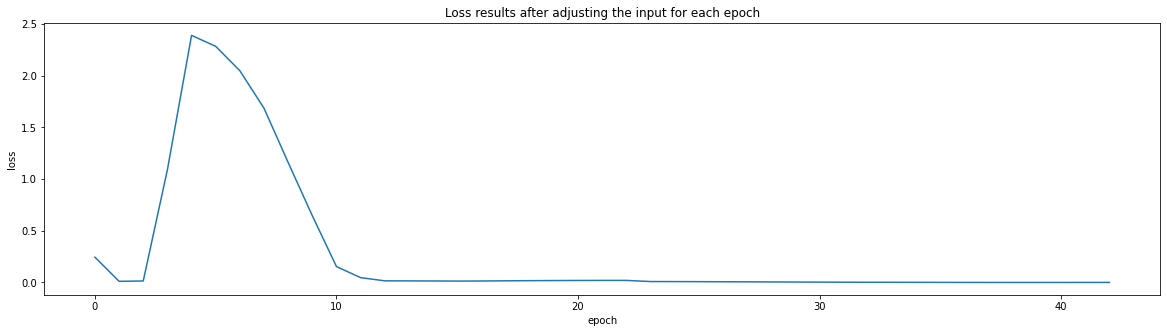

In [72]:
plt.figure(figsize=(20,5))
plt.plot(losses)
plt.title("Loss results after adjusting the input for each epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.savefig(f"{pred_path}/loss.png")
plt.show()

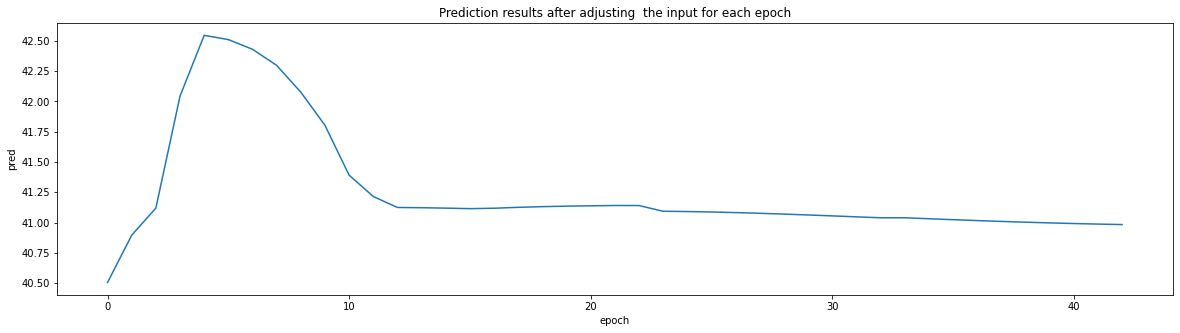

In [73]:
plt.figure(figsize=(20,5))
plt.plot(preds)
plt.title("Prediction results after adjusting  the input for each epoch")
plt.xlabel("epoch")
plt.ylabel("pred")
plt.savefig(f"{pred_path}/pred.png")
plt.show()

#### Save output

In [74]:
X = pd.DataFrame(X, columns = features, index = ["new"])
update = pd.concat([input_X, X]).T
update["fixed"] = fixed_mask
update["change"] = update.eval("(init != new)").astype(int)

# 檢測是否有不可調動的參數被調動
# update["check"] = update.eval("not ((init != new) & fixed)").astype(int)
# update["pred"] = round(pred_round1, 1)
update

,init,new,fixed,change
dry_strength_use,0.0,0.00,1.0,0
#1_Turbine_Motor_Side_Pressure,-35.3,-36.51,0.0,1
#1_Turbine_Free_Side_Pressure,-33.3,-33.81,0.0,1
#1_Turbine_Negative_Pressure,-34.3,-35.96,0.0,1
#1_Turbine_Negative_Pressure.1,88.0,88.00,1.0,0
#1_Turbine_Main_Motor_Current,78.3,77.83,0.0,1
#1_Vacuum_Pump_Motor_Side_Vibration,18.6,18.60,1.0,0
#1_Vacuum_Pump_Free_Side_Vibration,7.0,7.00,1.0,0
#2_Turbine_Motor_Side_Pressure,-40.5,-40.89,0.0,1
#2_Turbine_Free_Side_Pressure,-54.0,-54.00,1.0,0


In [75]:
update = update.T.to_dict()
update[target] = {"init": target1, "new": pred_round1}
update["status"] = "success"
update["reason"] = ""
with open(output_path, 'w') as f:
    json.dump(update, f)